### Loading Libraries

In [6]:
# Basic Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import itertools as it
from collections import Counter
import pickle
import sys
from google.colab import drive

# NLP libraries
import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stpwords = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
#from thundersvm import SVC
from sklearn import preprocessing, svm
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import cosine,cdist
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Defining Helper Functions

In [36]:
def clean_text(text):
  text = text.lower()
  text = re.sub("'", "", text) # to avoid removing contractions in english
  text = re.sub(r'\$\w*', '', text)
  text = re.sub(r'\'s', '', text)
  text = re.sub(r'<br />', '', text)
  text = re.sub(r'^RT[\s]+', '', text)
  #text = re.sub("@[A-Za-z0-9_]+","", text)
  #text = re.sub("#[A-Za-z0-9_]+","", text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub('[()!?]', ' ', text)
  text = re.sub('\[.*?\]',' ', text)
  text = re.sub("[^a-z0-9]"," ", text)
  text_links_removed = "".join([char for char in text if char not in string.punctuation])
  text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)])
  text = " ".join([lemmatizer.lemmatize(word) for word in re.split('\W+', text_cleaned)])
  text = text.strip()
  return text

def count_common_words(row):
    q1_words = set(map(lambda word: word.lower().strip(), row['question1'].split()))
    q2_words = set(map(lambda word: word.lower().strip(), row['question2'].split()))    
    return len(q1_words & q2_words)

def count_total_words(row):
    q1_words = set(map(lambda word: word.lower().strip(), row['question1'].split()))
    q2_words = set(map(lambda word: word.lower().strip(), row['question2'].split()))    
    return (len(q1_words) + len(q2_words))


def calculate_normalized_word_share(row):
    q1_words = set(map(lambda word: word.lower().strip(), row['question1'].split()))
    q2_words = set(map(lambda word: word.lower().strip(), row['question2'].split()))    
    return 1.0 * len(q1_words & q2_words) / (len(q1_words) + len(q2_words))

def is_not_present(a,b):
  a = a.lower()
  b = b.lower()
  if ('not' in a) | ('not' in b):
    if ('not' in a and 'not' not in b) | ('not' in b and 'not' not in a):
      return 1
    else:
      return -1
  else:
    return 0



def preprocess_data(data, embedding_df):
    
    print("\n### CLEANING DATASET ###")
    print('Shape of dataset before cleaning', data.shape)
    
    #data['question1'] = data['question1'].apply(clean_text)
    #data['question2'] = data['question2'].apply(clean_text)
    print('Shape of dataset after cleaning', data.shape)
    
    print('### Merging Embeddings to dataset ###')
    final_df = pd.merge(data,embedding_df, how = 'inner',left_on = 'qid1',right_on = 'qid')
    final_df = pd.merge(final_df,embedding_df, how = 'inner',left_on = 'qid2',right_on = 'qid', suffixes= ('_1_embedding','_2_embedding') )

    print('\n\n### Creating New Features ###')
    ## Length of each question
    final_df['q1_length'] = final_df['question1'].str.len()
    final_df['q2_length'] = final_df['question2'].str.len()

    ## Number of words in each question
    final_df['q1_word_count'] = final_df['question1'].apply(lambda x: len(x.split()))
    final_df['q2_word_count'] = final_df['question2'].apply(lambda x: len(x.split()))

    ## Number of common words in the dataset
    final_df['common_word_count'] = final_df.apply(count_common_words, axis=1)
    final_df['total_word_count'] = final_df.apply(count_total_words, axis=1)

    ## Normalized word share
    final_df['normalized_word_share'] = final_df.apply(calculate_normalized_word_share, axis=1)

    ## Euclidean Distance
    final_df['euclidean_dis'] = final_df.apply(lambda x: euclidean_dist(x.question_1_embedding, x.question_2_embedding), axis=1)

    ## Cosine Distance
    final_df['cosine_dis'] = final_df.apply(lambda x: cosine(x.question_1_embedding, x.question_2_embedding), axis=1)
    
    ## Negation
    final_df['is_negation'] = final_df.apply(lambda row: is_not_present(row['question1'],row['question2']),axis = 1)
    
    return final_df



def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic on Test set')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

def run_model(X, y, model, test_size):

  print('### Train - Test Split ###')
  x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=100)
  print('Shape of x_train',x_train.shape)
  print('Shape of x_test',x_test.shape)
  print('Shape of y_train',y_train.shape)
  print('Shape of x_test',y_test.shape)

  if model == 'Naive Bayes':
    model = GaussianNB()
    print("## Training Naive Bayes Model ##")
  elif model == 'XGBoost':
    model = XGBClassifier(random_state = 50, max_depth = 300)
    print("## Training XGBoost Model ##")
  elif model == 'SVC':
    model = svm.SVC(kernel='rbf')
    print("## Training SVC Model ##")
  elif model == 'LR':
    model = LogisticRegression(random_state = 100)
    print("## Training Logistic Regression Model ##")
  elif model == 'RF':
    model = RandomForestClassifier(random_state = 100,max_depth = 300)
    print("## Training Random Forest Model ##")
  
  model.fit(x_train, y_train)

  print("## PREDICTING on Train set ##")
  preds_train = model.predict(x_train)

  print('### CLASSIFICATION REPORT on Train set ###\n')
  print(classification_report(y_train,preds_train))

  print("## PREDICTING on Test set ##")
  preds_test = model.predict(x_test)

  print('### CLASSIFICATION REPORT on Test set ###')
  print(classification_report(y_test,preds_test))

  buildROC(y_test,preds_test)

  return model

def undersample_df(df):
  df_minor = df[df['is_duplicate'] == 1]
  df_major = df[df['is_duplicate'] == 0]

  df_un_major = df_major.sample(len(df_minor))
  merged_df = pd.concat([df_minor,df_un_major])
  return merged_df

def euclidean_dist(p1,p2):
  
  dist = np.linalg.norm(p1 - p2)

  return dist

def load_embedding_file(path):

  with open(path, 'rb') as fp:
    embedding_df = pickle.load(fp)
  fp.close()
  print('Null Check in Embedding file')
  print(embedding_df.isnull().sum())

  print('Shape of Embedding file')
  print(embedding_df.shape)

  return embedding_df

### Loading Dataset

In [8]:
data_org = pd.read_csv("train.csv")
data_org.dropna(inplace = True)
print(data_org.shape)
data_org.head()

(404287, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Loading Embeddings

In [ ]:
### Use the method below if the embedding files are on the google drive. 
### If not, use the method approporiate to where the files are stored

drive.mount('/content/drive',force_remount = True)

print('### Loading Glove Embeddings ###')
glove_path = '/content/drive/My Drive/quora_glove_embeddings_final.pkl'
glove_embeddings_df = load_embedding_file(glove_path)

print('\n\n### Loading Bert Embeddings ###')
bert_path = '/content/drive/My Drive/quora_bert_embeddings_final.pkl'
bert_embeddings_df = load_embedding_file(bert_path)

Mounted at /content/drive
### Loading Glove Embeddings ###
Null Check in Embedding file
index       0
qid         0
question    0
dtype: int64
Shape of Embedding file
(537931, 3)


### Loading Bert Embeddings ###


### Preprocessing Dataset

In [47]:
### Choose the embedding df here. 

model_df = preprocess_data(data_org, glove_embeddings_df)

print('### Balance of classes ###')
print(model_df['is_duplicate'].value_counts()/len(model_df['is_duplicate']))
print(model_df.columns)
print(model_df.shape)
model_df.head()


### CLEANING DATASET ###
Shape of dataset before cleaning (404287, 6)
Shape of dataset after cleaning (404287, 6)
### Merging Embeddings to dataset ###


### Creating New Features ###


/usr/local/lib/python3.8/dist-packages/scipy/spatial/distance.py:699: RuntimeWarning:

invalid value encountered in float_scalars



### Balance of classes ###
0    0.630799
1    0.369201
Name: is_duplicate, dtype: float64
Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'index_1_embedding', 'qid_1_embedding', 'question_1_embedding',
       'index_2_embedding', 'qid_2_embedding', 'question_2_embedding',
       'q1_length', 'q2_length', 'q1_word_count', 'q2_word_count',
       'common_word_count', 'total_word_count', 'normalized_word_share',
       'euclidean_dis', 'cosine_dis', 'is_negation'],
      dtype='object')
(404287, 22)


,id,qid1,qid2,question1,question2,is_duplicate,index_1_embedding,qid_1_embedding,question_1_embedding,index_2_embedding,...,q1_length,q2_length,q1_word_count,q2_word_count,common_word_count,total_word_count,normalized_word_share,euclidean_dis,cosine_dis,is_negation
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0,1,"[-0.04227572, -0.11327143, 0.13813184, -0.1614...",404290,...,66,57,14,12,10,23,0.434783,1.011800,0.033067,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,3,"[0.22196, -0.039861504, -0.075059, -0.00718250...",17296,...,51,88,8,13,4,20,0.200000,2.805261,0.348044,0
2,184732,3,282170,What is the story of Kohinoor (Koh-i-Noor) Dia...,Is it possible to melt down diamonds?,0,1,3,"[0.22196, -0.039861504, -0.075059, -0.00718250...",589022,...,51,37,8,7,1,15,0.066667,4.547195,0.703321,0
3,263614,3,380197,What is the story of Kohinoor (Koh-i-Noor) Dia...,What are some interesting facts about Kohinoor...,0,1,3,"[0.22196, -0.039861504, -0.075059, -0.00718250...",667904,...,51,55,8,8,3,16,0.187500,2.702111,0.290333,0
4,359232,3,488853,What is the story of Kohinoor (Koh-i-Noor) Dia...,Could India keep the Koh-I-Noor safe?,0,1,3,"[0.22196, -0.039861504, -0.075059, -0.00718250...",763522,...,51,37,8,6,1,14,0.071429,4.263339,0.631314,0


In [48]:
### Select Required Features
features = ['is_negation','q1_length', 'q2_length', 'q1_word_count', 'q2_word_count',
       'common_word_count', 'total_word_count', 'normalized_word_share','euclidean_dis','cosine_dis']

target = 'is_duplicate'
required_columns = features.copy()
required_columns.append(target)
required_columns


['is_negation',
 'q1_length',
 'q2_length',
 'q1_word_count',
 'q2_word_count',
 'common_word_count',
 'total_word_count',
 'normalized_word_share',
 'euclidean_dis',
 'cosine_dis',
 'is_duplicate']

In [49]:
model_df = model_df[required_columns]
print(model_df.shape)
model_df.head()

(404287, 11)


,is_negation,q1_length,q2_length,q1_word_count,q2_word_count,common_word_count,total_word_count,normalized_word_share,euclidean_dis,cosine_dis,is_duplicate
0,0,66,57,14,12,10,23,0.434783,1.011800,0.033067,0
1,0,51,88,8,13,4,20,0.200000,2.805261,0.348044,0
2,0,51,37,8,7,1,15,0.066667,4.547195,0.703321,0
3,0,51,55,8,8,3,16,0.187500,2.702111,0.290333,0
4,0,51,37,8,6,1,14,0.071429,4.263339,0.631314,0


### Train - Test Split ###
Shape of x_train (323429, 10)
Shape of x_test (80858, 10)
Shape of y_train (323429,)
Shape of x_test (80858,)
## Training XGBoost Model ##
## PREDICTING on Train set ##
### CLASSIFICATION REPORT on Train set ###

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    204061
           1       0.99      0.99      0.99    119368

    accuracy                           0.99    323429
   macro avg       0.99      0.99      0.99    323429
weighted avg       0.99      0.99      0.99    323429

## PREDICTING on Test set ##
### CLASSIFICATION REPORT on Test set ###
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     50963
           1       0.65      0.67      0.66     29895

    accuracy                           0.74     80858
   macro avg       0.73      0.73      0.73     80858
weighted avg       0.75      0.74      0.74     80858



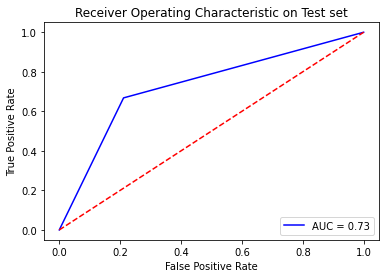

In [53]:
### Choose the required model type and other parameters here. 

y = model_df[target]
X = model_df[features]
test_size = 0.2
model = 'XGBoost' # Choose between : Naive Bayes, XGBoost, SVC (takes too long to train), LR , RF
trained_model = run_model(X, y, model, test_size)


### Saving best model into pickle file

In [42]:
model_dict = {'model':trained_model,'features': features}
with open('quora_question_pairs_best_model.pkl', 'wb') as fp:
        pickle.dump(model_dict, fp)

fp.close() 

### Moving the pickle file to google drive

In [43]:
import shutil
colab_link = "/content/quora_question_pairs_best_model.pkl"
gdrive_link = "/content/drive/MyDrive/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/quora_question_pairs_best_model.pkl'

### Creating visualization results 

In [67]:
xgb1 = ('XGBoost','Bert',0.76,0.76,0.76)
xgb2 = ('XGBoost','Glove',0.74,0.74,0.75)
RF1 = ('Random Forest','Bert',0.79,0.79,0.79)
RF2 = ('Random Forest','Glove',0.78,0.78,0.78)
LR1 = ('Logistic Regression','Bert',0.73,0.73,0.72)
LR2 = ('Logistic Regression','Glove',0.67,0.67,0.67)
NB1 = ('Naive Bayes','Bert',0.70,0.70,0.75)
NB2 = ('Naive Bayes','Glove',0.68,0.68,0.74)
results_df = [xgb1,xgb2,RF1,RF2,LR1,LR2,NB1,NB2]
results_df = pd.DataFrame(results_df,columns =['Model', 'Embedding Method', 'Accuracy','Recall','Precision'])

In [68]:
results_df.head()

,Model,Embedding Method,Accuracy,Recall,Precision
0,XGBoost,Bert,0.76,0.76,0.76
1,XGBoost,Glove,0.74,0.74,0.75
2,Random Forest,Bert,0.79,0.79,0.79
3,Random Forest,Glove,0.78,0.78,0.78
4,Logistic Regression,Bert,0.73,0.73,0.72


In [69]:
import plotly.express as px
plot_df = results_df[['Model','Embedding Method','Accuracy']]
df = px.data.tips()
fig = px.bar(plot_df, x="Model", y="Accuracy",
             color='Embedding Method', barmode='group',
             height=400,title="Accuracy scores across models", color_discrete_sequence=["orange", "red"])
fig.show()

In [70]:
plot_df = results_df[['Model','Embedding Method','Recall']]
df = px.data.tips()
fig = px.bar(plot_df, x="Model", y="Recall",
             color='Embedding Method', barmode='group',
             height=400,title="Recall scores across models",color_discrete_sequence=["blue", "green"])
fig.show()

In [71]:
plot_df = results_df[['Model','Embedding Method','Precision']]
df = px.data.tips()
fig = px.bar(plot_df, x="Model", y="Precision",
             color='Embedding Method', barmode='group',
             height=400,title="Precision scores across models",color_discrete_sequence=["lightgreen", "darkred"])
fig.show()